In [ ]:
!pip install tensorflow

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from keras import Model, layers
from keras.models import load_model, model_from_json
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization

from tensorflow.keras import regularizers

In [ ]:
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

In [ ]:
print(tf.__version__)
print(tf.config.list_logical_devices('GPU'))

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.18.0
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


True

In [ ]:
data_path = '/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/EyeDiseaseDataset'

# Data Augmentation
datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
    )
# Train generator (80%)
train_generator = datagen.flow_from_directory(
    data_path,
    subset='training',
    batch_size=32,
    class_mode='categorical',
    target_size=(256, 256),
    shuffle=True,
    )
# Validation generator (20%)
validation_generator = datagen.flow_from_directory(
    data_path,
    subset='validation',
    shuffle=False,
    class_mode='categorical',
    batch_size=32,
    target_size=(256, 256)
    )

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy tên lớp
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# Lấy số lượng mẫu trong từng tập
train_size = train_generator.samples
val_size = validation_generator.samples

# Vẽ biểu đồ
dataset_sizes = [train_size, val_size]
dataset_labels = ['Train', 'Validation']

plt.figure(figsize=(8, 6))
plt.bar(dataset_labels, dataset_sizes, color=['blue', 'orange'])
plt.title('Dataset Sizes')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')

# Thêm nhãn số trên cột
for i, size in enumerate(dataset_sizes):
    plt.text(i, size + 20, str(size), ha='center', va='bottom')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy tên lớp
class_names = list(train_generator.class_indices.keys())

def plot_class_distribution_pie(generator, generator_name):
    labels = generator.classes
    class_counts = np.bincount(labels)

    plt.figure(figsize=(8, 6))
    plt.pie(class_counts, labels=class_names,
            autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Paired.colors[:len(class_names)])
    plt.title(f'Class Distribution in {generator_name} Set (Pie Chart)')
    plt.axis('equal')
    plt.show()

# Vẽ biểu đồ phân bố lớp
plot_class_distribution_pie(train_generator, 'Train')
plot_class_distribution_pie(validation_generator, 'Validation')

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(4, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)
models = Model(inputs=base_model.input, outputs=predictions)
models.summary()

<ipython-input-6-02d4f34bd1bb>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 2,881,796 (10.99 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/bestweight_1.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)
csv_logger_callback = CSVLogger(
    '/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/training_history_1.csv', append=True
)
models.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [ ]:
# Train the model
history = models.fit(
    x=train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_callback, csv_logger_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7036 - loss: 5.8130 
Epoch 1: val_accuracy improved from -inf to 0.28875, saving model to /content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/bestweight_1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 2475s 24s/step - accuracy: 0.7045 - loss: 5.7934 - val_accuracy: 0.2887 - val_loss: 19.3897
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8474 - loss: 1.0415
Epoch 2: val_accuracy improved from 0.28875 to 0.47500, saving model to /content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/bestweight_1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8475 - loss: 1.0395 - val_accuracy: 0.4750 - val_loss: 7.2437
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8819 - loss: 0.5169
Epoch 3: val_accuracy improved from 0.47500 to 0.51375, saving model to /content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/bestweight_1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8819 - loss: 0.5165 - val_accuracy: 0.5138 - val_loss: 6.2558
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9130 - loss: 0.3340
Epoch 4: val_accuracy did not improve from 0.51375
100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9129 - loss: 0.3342 - val_accuracy: 0.4888 - val_loss: 7.0507
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8844 - loss: 0.3834
Epoch 5: val_accuracy did not improve from 0.51375
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8845 - loss: 0.3832 - val_accuracy: 0.3088 - val_loss: 10.6030
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9183 - loss: 0.3009
Epoch 6: val_accuracy improved from 0.51375 to 0.59625, saving model to /content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/bestweight_1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9182 - loss: 0.3011 - val_accuracy: 0.5962 - val_loss: 3.8432
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9072 - loss: 0.3087
Epoch 7: val_accuracy did not improve from 0.59625
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9072 - loss: 0.3087 - val_accuracy: 0.5088 - val_loss: 3.9260
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9186 - loss: 0.2852
Epoch 8: val_accuracy did not improve from 0.59625
100/100 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9185 - loss: 0.2855 - val_accuracy: 0.5775 - val_loss: 3.6560
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9198 - loss: 0.2748
Epoch 9: val_accuracy did not improve from 0.59625
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9198 - loss: 0.2748 - val_accuracy: 0.3875 - val_loss: 6.4681
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9221 - loss: 0.2704
Epoch 10: val_accuracy did not imp

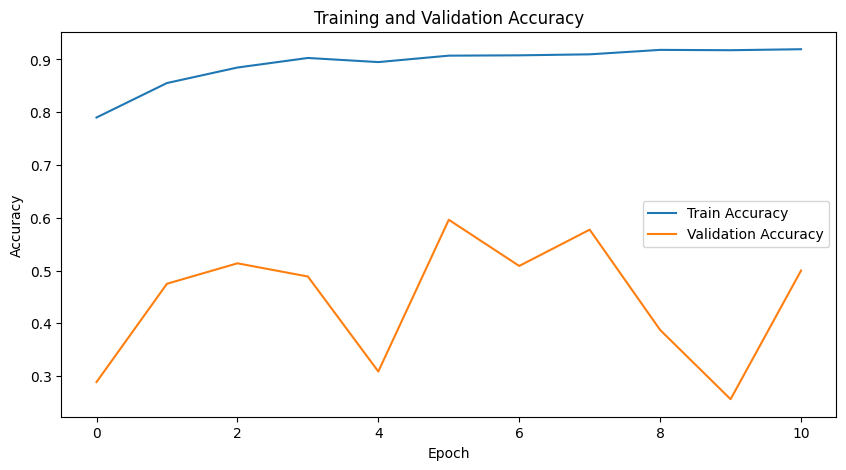

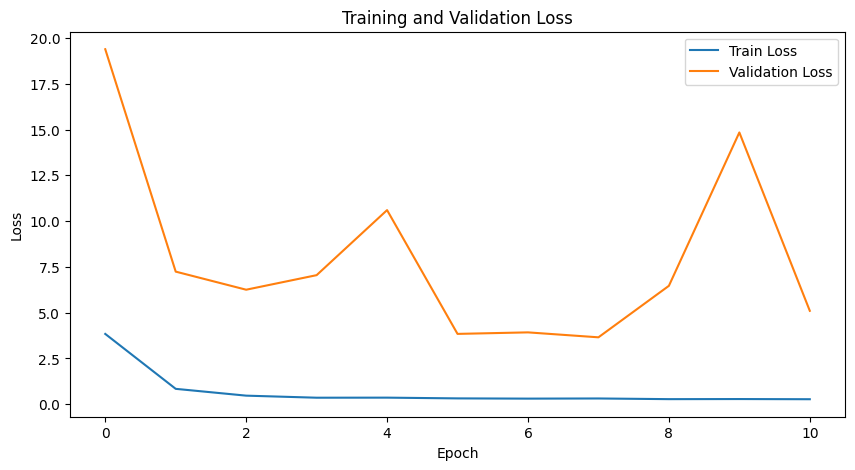

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.read_csv('/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/training_history_1.csv')

# Vẽ Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/accuracy_plot.webp', format='webp')
plt.show()

# Vẽ Loss
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_2/loss_plot.webp', format='webp')
plt.show()